Let's re-do some of the calculations of the previous exercise to appreciate the power of switching to JAX control flow operations.

<br>

**Recap**

In [13]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import pandas as pd
import jax
from iminuit import Minuit

# I converted the root dataset to a dataframe for simplicity 
df_WW = pd.read_hdf('./data_WW_wPred_wSyst.h5', key='dataset')

# Extract the signal and background: label 1 -> Signal, label 0 -> Bkg
df_WW_Sig = df_WW[df_WW.label==1]
df_WW_Bkg = df_WW[df_WW.label==0]

In [14]:
import numpy as np

# I stored the BDT outputs for each entry in the dataset. Let us now extract them
obs_sig = df_WW_Sig.BDT_pred.ravel()
obs_bkg = df_WW_Bkg.BDT_pred.ravel()

# Fill Histograms

xmin = np.amin(obs_bkg)
xmax = np.amax(obs_sig)

bins = np.linspace(xmin, xmax, num=10)

hist_sig, _ = np.histogram(obs_sig, bins, weights=df_WW_Sig.mcWeight)     # Note how we fill the histogram with MC weights
hist_bkg, _ = np.histogram(obs_bkg, bins, weights=df_WW_Bkg.mcWeight)

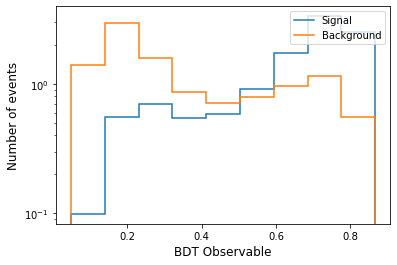

In [15]:
# To see better the separation power of the discriminant, we can also plot the normalized histograms

import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal', density=1)
hep.histplot(hist_bkg, bins, label='Background', density=1)

plt.xlabel('BDT Observable', size=12)
plt.ylabel('Number of events', size=12)
plt.legend(loc='upper right')
plt.yscale('log')

In [16]:
# The so called Asimov expected events (the exact number of events we would expect to observe if the 
# nominal mu=1 hypothesis is correct)

N_obs_Asimov = hist_sig + hist_bkg

print("The expected number of events in each bin of the discriminant: \n")
print(N_obs_Asimov)


The expected number of events in each bin of the discriminant: 

[ 81.44700434 173.27195032  94.42159246  51.71184839  42.99699869
  47.76060627  59.97951239  73.95018394  37.93186379]


<br>

In [17]:
# The polynomial part of the equation above - no need to be bogged down with the details here
def poly_interp(alpha, varUp, varDown, varNom):
    
    # Calculate the co-efficients a_i 
    pow_up = jnp.divide(varUp,varNom)
    pow_down = jnp.divide(varDown,varNom)
    logHi = jnp.log(jnp.clip(pow_up,1e-7,None))
    logLo = jnp.log(jnp.clip(pow_down,1e-7,None))
    logHi = jnp.log(pow_up)
    logLo = jnp.log(pow_down)
    pow_up_log = jnp.multiply(pow_up,logHi)
    pow_down_log = -jnp.multiply(pow_down,logLo)
    pow_up_log2 = jnp.multiply(pow_up_log,logHi)
    pow_down_log2 = -jnp.multiply(pow_down_log,logLo)
    
    S0 = (pow_up+pow_down)/2.0
    A0 = (pow_up-pow_down)/2.0
    S1 = (pow_up_log+pow_down_log)/2.0
    A1 = (pow_up_log-pow_down_log)/2.0
    S2 = (pow_up_log2+pow_down_log2)/2.0
    A2 = (pow_up_log2-pow_down_log2)/2.0
 
    a1 = (15*A0-7*S1+A2)/8.0
    a2 = (-24+24*S0-9*A1+S2)/8.0
    a3 = (-5*A0+5*S1-A2)/4.0
    a4 = (12-12*S0+7*A1-S2)/4.0
    a5 = (3*A0-3*S1+A2)/8.0
    a6 = (-8+8*S0-5*A1+S2)/8.0

    return 1.0 + alpha * (a1 + alpha * ( a2 + alpha * ( a3 + alpha * ( a4 + alpha * ( a5 + alpha * a6 ) ) ) ) )
    

# The exponential part of the equation above - for extrapolation
def exp_interp(alpha, varUp, varDown, varNom):
    
    return jnp.where(alpha>1.0, (varUp/varNom)**alpha, (varDown/varNom)**(-alpha))


# Calculate the net yield, but now with systematic NP modif-iable histograms
def sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big):
    
    sigma_mu_binned = mu*hist_sig*fact_sig + hist_bkg*fact_big
                        
    return sigma_mu_binned


<br>

In [18]:
# Let's extract the systematic variations (start with only signal so you can follow the code)

NP_size = 100

arr_ratio_up_sig = [[1.0 for i in range(len(hist_sig))] for j in range(NP_size)]
arr_ratio_down_sig = [[1.0 for i in range(len(hist_sig))] for j in range(NP_size)]

for count in range(NP_size):
    
    systematic_name = 'syst_'+str(count)
    
    # Calculate the net weight variations for each of the systematics
    weight_up_sig = df_WW_Sig[systematic_name+'_up']*df_WW_Sig['mcWeight']
    weight_down_sig = df_WW_Sig[systematic_name+'_down']*df_WW_Sig['mcWeight']
    
    # Re-fill the histogram with new weights
    hist_sig_up, _ = np.histogram(obs_sig, bins, weights=weight_up_sig)
    hist_sig_down, _ = np.histogram(obs_sig, bins, weights=weight_down_sig)
    
    
    # Extract the up and down variations as a function of the discriminant histogram bins
    arr_ratio_up_sig[count] = jnp.array(1.0+(hist_sig_up - hist_sig))
    arr_ratio_down_sig[count] = jnp.array(1.0+(hist_sig_down - hist_sig))
    

<br>

In [19]:
# Let's do the same for bkg

arr_ratio_up_bkg = [[1.0 for i in range(len(hist_bkg))] for j in range(NP_size)]
arr_ratio_down_bkg = [[1.0 for i in range(len(hist_bkg))] for j in range(NP_size)]

for count in range(NP_size):
    
    systematic_name = 'syst_'+str(count)
    
    weight_up_bkg = df_WW_Bkg[systematic_name+'_up'].ravel()*df_WW_Bkg.mcWeight.ravel()
    weight_down_bkg = df_WW_Bkg[systematic_name+'_down'].ravel()*df_WW_Bkg.mcWeight.ravel()

    hist_bkg_up, _ = np.histogram(obs_bkg, bins, weights=weight_up_bkg)
    hist_bkg_down, _ = np.histogram(obs_bkg, bins, weights=weight_down_bkg)
    
    arr_ratio_up_bkg[count] = jnp.array(1.0+(hist_bkg_up - hist_bkg))
    arr_ratio_down_bkg[count] = jnp.array((1.0+(hist_bkg_down - hist_bkg)))


<br>

In [20]:
# Convert everything to JAX numpy arrays
N_obs_Asimov = jnp.array(N_obs_Asimov)

hist_sig = jnp.array(hist_sig)
hist_bkg = jnp.array(hist_bkg)

<br>

In [21]:
# Re-define the function to take into account systematic variations
def NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov):
    
    mu = param_array[0]
    
    # Initialize the modification arrays
    fact_sig = jnp.ones_like(hist_sig)
    fact_bkg = jnp.ones_like(hist_sig)
    
    for n in range(1, param_array.shape[0]):
         
        # Find the modification factor for any value of parameter based on interpolation techniques
        fact_sig *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0))   
        fact_bkg *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0))      

    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_bkg)
    
    # Notice the last term coming from the log of subsidiary likelihood 
    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum() + jnp.sum(param_array[1:]**2)
        
    return llr



def NLL_minuit(param_array):
    
    return NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)



<br>

In [24]:
# Re-do the fit with 20 NPs

tuple_syst = [0.0] * (21) 
tuple_syst[0] = 1.0 

list_names = ['syst_'+str(i) for i in range(len(tuple_syst)-1)]
list_names.insert(0, 'mu')
print(str(list_names)+'\n')

# Convert to JAX array
tuple_syst = jnp.array(tuple_syst, dtype='float32')

# JITT-ed NLL_minuit function
m1 = Minuit(jax.jit(NLL_minuit), tuple(tuple_syst), grad=None, name=tuple(list_names))
m1.precision = 1e-7
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

['mu', 'syst_0', 'syst_1', 'syst_2', 'syst_3', 'syst_4', 'syst_5', 'syst_6', 'syst_7', 'syst_8', 'syst_9', 'syst_10', 'syst_11', 'syst_12', 'syst_13', 'syst_14', 'syst_15', 'syst_16', 'syst_17', 'syst_18', 'syst_19']



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4539                      │              Nfcn = 718              │
│ EDM = 0.000288 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │    1.0    │    0.9    │            │            │         │         │       │
│ 1 │ syst_0  │    0.0    │    0.9    │            │            │         │         │       │
│ 2 │ syst_1  │    0.0    │    0.9    │            │            │         │         │       │
│ 3 │ syst_2  │    0.0    │    0.9    │            │            │         │         │       │
│ 4 │ syst_3  │     0     │     1     │            │            │         │         │       │
│ 5 │ syst_4  │    0.0    │    0.8    │            │            │         │         │       │
│ 6 │ syst_5  │    0.0    │    0.9    │            │            │         │         │       │
│ 7 │ syst_6  │    0.0    │    0.9    │            │            │         │         │       │
│ 8 │ syst_7  │    0.0    │    0.9    │            │            │         │         │       │
│ 9 │ syst_8  │    0.0    │    0.9    │            │            │         │         │       │
│ 10│ syst_9  │    0.0    │    0.9    │            │            │         │         │       │
│ 11│ syst_10 │    0.0    │    0.9    │            │            │         │         │       │
│ 12│ syst_11 │    0.0    │    0.8    │            │            │         │         │       │
│ 13│ syst_12 │    0.0    │    0.9    │            │            │         │         │       │
│ 14│ syst_13 │    0.0    │    0.9    │            │            │         │         │       │
│ 15│ syst_14 │     0     │     1     │            │            │         │         │       │
│ 16│ syst_15 │    0.0    │    0.8    │            │            │         │         │       │
│ 17│ syst_16 │    0.0    │    0.8    │            │            │         │         │       │
│ 18│ syst_17 │    0.0    │    0.9    │            │            │         │         │       │
│ 19│ syst_18 │    0.0    │    0.9    │            │            │         │         │       │
│ 20│ syst_19 │    0.0    │    0.9    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu    syst_0    syst_1    syst_2    syst_3    syst_4    syst_5    syst_6    syst_7    syst_8    syst_9   syst_10   syst_11   syst_12   syst_13   syst_14   syst_15   syst_16   syst_17   syst_18   syst_19 │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │     0.777    -0.167    0.0324      0.16   -0.0926    0

<br>

Now let's see how JAX makes the computation chart for this JIT-compiled function:

<br>

In [ ]:
# I have intentionally left the output blank because GitHub doesn't support scrollable outputs
# You can run this yourself

print(jax.make_jaxpr(jax.jit(NLL))(tuple_syst))

<br>

<br>

**Exercise**

<br>

In the lecture today, you saw how using JAX's primitive control flow operations like `lax.for_loop` can more efficiently work with JIT compilation.

<br>

Modify the test statistic function `NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)` to now use `lax.for_loop` instead of the regular for loop.

<br>

If you can also try to replace `jnp.where` wrapper of JAX with more primitive operations for a further efficiency boost. See https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow for more primitive operations.

<br>

In [ ]:
# Define a new test statistic function with JAX control flow

def NLL_JCF(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, 
            arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov):
    
    
    
    
    
    
    
    


<br>

In [ ]:
# Now see how this function is treated by JAX - Does it look better?

print(jax.make_jaxpr(jax.jit(NLL_JCF))(tuple_syst))

<br>

Now let's time it - see if it is indeed better at compilation time compared to the old function.

<br>

In [ ]:
# You need to re-define the original function so as to avoid using a previously compiled function

def NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov):
    
    mu = param_array[0]
    
    # Initialize the modification arrays
    fact_sig = jnp.ones_like(hist_sig)
    fact_bkg = jnp.ones_like(hist_sig)
    
    for n in range(1, param_array.shape[0]):
         
        # Find the modification factor for any value of parameter based on interpolation techniques
        fact_sig *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0))   
        fact_bkg *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0))      

    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_bkg)
    
    # Notice the last term coming from the log of subsidiary likelihood 
    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum() + jnp.sum(param_array[1:]**2)
        
    return llr


<br>

In [ ]:
%%timeit -n1 -r1

NLL(tuple_syst, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, 
            arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)

<br>

In [ ]:
%%timeit -n1 -r1

NLL_JCF(tuple_syst, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, 
            arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)